# Semantic Similarity Rating (SSR) - Step-by-Step Demo

This notebook demonstrates how **Semantic Similarity Rating (SSR)** converts natural language text responses into quantitative probability distributions.

Based on the paper: [arXiv:2510.08338v2](https://arxiv.org/abs/2510.08338)

## What is SSR?

SSR is a method that:
- Takes a **text response** (e.g., "I really love this product!")
- Compares it semantically to **reference statements** for each rating scale point
- Outputs a **probability distribution** over the rating scale

This allows us to get both **natural language richness** and **quantitative rigor** in a single methodology!

## Setup

First, let's import the necessary libraries and set up our environment.

In [11]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add backend directory to path
backend_path = Path.cwd() / 'backend'
if str(backend_path) not in sys.path:
    sys.path.insert(0, str(backend_path))

from ssr_core.ssr_model import SemanticSimilarityRater

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful!")
print(f"✓ Backend path: {backend_path}")

✓ Imports successful!
✓ Backend path: /Users/mark.stent/Library/CloudStorage/OneDrive-AllwynInternationala.s/Documents/python/sage/backend


## Initialize the SSR Model

We'll create an instance of the `SemanticSimilarityRater` with default parameters:
- **Model**: `text-embedding-3-small` (OpenAI)
- **Temperature**: 0.5 (controls distribution spread)
- **Normalization**: "paper" method (from arXiv:2510.08338v2)

In [12]:
# Initialize SSR model
ssr = SemanticSimilarityRater(
    model_name="text-embedding-3-small",
    temperature=0.5,
    normalize_method="paper"
)

print(f"✓ SSR Model initialized")
print(f"  - Embedding Model: {ssr.model_name}")
print(f"  - Temperature: {ssr.temperature}")
print(f"  - Normalization: {ssr.normalize_method}")

✓ SSR Model initialized
  - Embedding Model: text-embedding-3-small
  - Temperature: 0.5
  - Normalization: paper


## Example 1: Simple Product Satisfaction Rating

Let's start with a simple example: rating product satisfaction on a 5-point scale.

### Step 1: Define the Rating Scale and Reference Statements

In [13]:
# Define a 5-point Likert scale for satisfaction
rating_scale = {
    1: "Very Dissatisfied - I am extremely unhappy with this product and would not recommend it.",
    2: "Dissatisfied - I am not satisfied with this product and have several complaints.",
    3: "Neutral - The product is okay, neither particularly good nor bad.",
    4: "Satisfied - I am happy with this product and would recommend it.",
    5: "Very Satisfied - I absolutely love this product and think it's excellent!"
}

# Display the scale
print("Rating Scale:")
print("=" * 80)
for score, statement in rating_scale.items():
    print(f"{score}: {statement}")
    print()

Rating Scale:
1: Very Dissatisfied - I am extremely unhappy with this product and would not recommend it.

2: Dissatisfied - I am not satisfied with this product and have several complaints.

3: Neutral - The product is okay, neither particularly good nor bad.

4: Satisfied - I am happy with this product and would recommend it.

5: Very Satisfied - I absolutely love this product and think it's excellent!



### Step 2: Collect a Text Response

Imagine a respondent gives this natural language response:

In [14]:
text_response = "I really love this product! It exceeded all my expectations and I use it every day."

print("Text Response:")
print("=" * 80)
print(f"\"{text_response}\"")

Text Response:
"I really love this product! It exceeded all my expectations and I use it every day."


### Step 3: Generate Embeddings

The SSR model generates semantic embeddings for:
1. The text response
2. Each reference statement in the rating scale

In [15]:
# Get embeddings (this happens internally in the SSR model)
print("Generating embeddings...")
print("This creates high-dimensional vectors (1536 dimensions) that capture semantic meaning.")
print("\nEmbedding process:")
print("  1. Text response → embedding vector")
print("  2. Each rating statement → embedding vector")
print("\n✓ Embeddings ready for similarity calculation")

Generating embeddings...
This creates high-dimensional vectors (1536 dimensions) that capture semantic meaning.

Embedding process:
  1. Text response → embedding vector
  2. Each rating statement → embedding vector

✓ Embeddings ready for similarity calculation


### Step 4: Calculate Cosine Similarities

We calculate the cosine similarity between the response and each reference statement.

In [16]:
# Calculate similarities
reference_statements = list(rating_scale.values())
similarities = ssr.calculate_similarities(text_response, reference_statements)

print("Cosine Similarities:")
print("=" * 80)
for score, similarity in zip(rating_scale.keys(), similarities):
    bar = '█' * int(similarity * 50)  # Visual bar
    print(f"Rating {score}: {similarity:.4f} {bar}")

Cosine Similarities:
Rating 1: 0.3351 ████████████████
Rating 2: 0.2513 ████████████
Rating 3: 0.2130 ██████████
Rating 4: 0.4116 ████████████████████
Rating 5: 0.5715 ████████████████████████████


### Step 5: Convert to Probability Distribution

Using the paper's normalization method:
1. Subtract minimum similarity (shift to positive range)
2. Apply temperature scaling
3. Normalize proportionally (sum to 1.0)

In [17]:
# Convert similarities to probabilities
probabilities = ssr.similarities_to_probabilities(similarities)

print("Probability Distribution:")
print("=" * 80)
for score, prob in zip(rating_scale.keys(), probabilities):
    bar = '█' * int(prob * 100)  # Visual bar
    print(f"Rating {score}: {prob:.4f} ({prob*100:.2f}%) {bar}")

print(f"\n✓ Sum of probabilities: {probabilities.sum():.6f} (should be 1.0)")

Probability Distribution:
Rating 1: 0.1703 (17.03%) █████████████████
Rating 2: 0.0534 (5.34%) █████
Rating 3: 0.0000 (0.00%) 
Rating 4: 0.2767 (27.67%) ███████████████████████████
Rating 5: 0.4996 (49.96%) █████████████████████████████████████████████████

✓ Sum of probabilities: 1.000000 (should be 1.0)


### Step 6: Visualize the Distribution

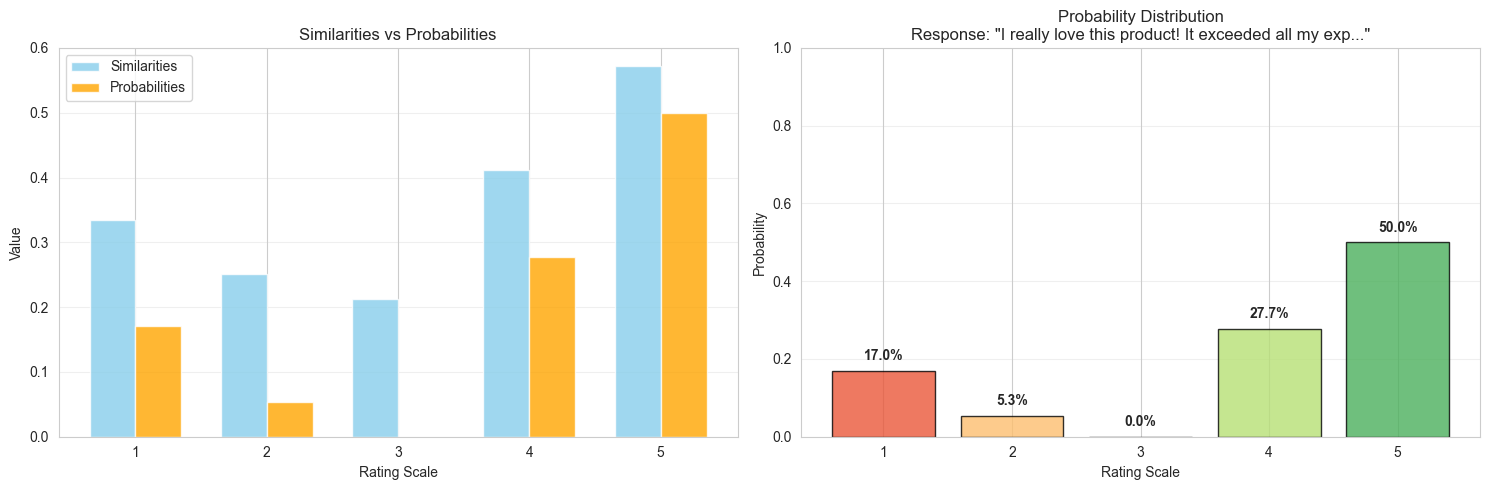

In [18]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Similarities vs Probabilities
x = list(rating_scale.keys())
width = 0.35
ax1.bar([i - width/2 for i in x], similarities, width, label='Similarities', alpha=0.8, color='skyblue')
ax1.bar([i + width/2 for i in x], probabilities, width, label='Probabilities', alpha=0.8, color='orange')
ax1.set_xlabel('Rating Scale')
ax1.set_ylabel('Value')
ax1.set_title('Similarities vs Probabilities')
ax1.legend()
ax1.set_xticks(x)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Probability Distribution
colors = sns.color_palette('RdYlGn', len(x))
ax2.bar(x, probabilities, color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Rating Scale')
ax2.set_ylabel('Probability')
ax2.set_title(f'Probability Distribution\nResponse: "{text_response[:50]}..."')
ax2.set_xticks(x)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (score, prob) in enumerate(zip(x, probabilities)):
    ax2.text(score, prob + 0.02, f'{prob*100:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Step 7: Calculate Distribution Metrics

Extract meaningful statistics from the probability distribution.

In [19]:
# Calculate metrics
mode = x[np.argmax(probabilities)]
expected_value = np.sum(np.array(x) * probabilities)
entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Add small value to avoid log(0)
max_entropy = np.log2(len(x))  # Maximum possible entropy

print("Distribution Metrics:")
print("=" * 80)
print(f"Mode (most likely rating): {mode}")
print(f"Expected Value (weighted average): {expected_value:.2f}")
print(f"Entropy: {entropy:.3f} bits (max: {max_entropy:.3f})")
print(f"Normalized Entropy: {entropy/max_entropy:.3f} (0=certain, 1=uniform)")
print()
print("Interpretation:")
print(f"  - The response is most similar to rating {mode}")
print(f"  - Overall weighted score: {expected_value:.2f}/5")
print(f"  - Certainty: {'High' if entropy/max_entropy < 0.5 else 'Low'} (lower entropy = more certain)")

Distribution Metrics:
Mode (most likely rating): 5
Expected Value (weighted average): 3.88
Entropy: 1.674 bits (max: 2.322)
Normalized Entropy: 0.721 (0=certain, 1=uniform)

Interpretation:
  - The response is most similar to rating 5
  - Overall weighted score: 3.88/5
  - Certainty: Low (lower entropy = more certain)


## Example 2: Comparing Multiple Responses

Let's see how SSR handles different sentiment levels in responses.

In [20]:
# Define multiple responses with different sentiments
responses = {
    "Very Positive": "I absolutely love this product! It's the best purchase I've made all year. Highly recommend!",
    "Positive": "This product is good. I'm satisfied with my purchase and would buy it again.",
    "Neutral": "The product is okay. It works as described but nothing special.",
    "Negative": "I'm disappointed with this product. It doesn't meet my expectations.",
    "Very Negative": "Terrible product! Complete waste of money. I regret buying it."
}

# Calculate distributions for all responses
distributions = {}
for label, response in responses.items():
    sims = ssr.calculate_similarities(response, reference_statements)
    probs = ssr.similarities_to_probabilities(sims)
    distributions[label] = probs
    print(f"✓ Processed: {label}")

✓ Processed: Very Positive
✓ Processed: Positive
✓ Processed: Neutral
✓ Processed: Negative
✓ Processed: Very Negative


### Visualize All Distributions

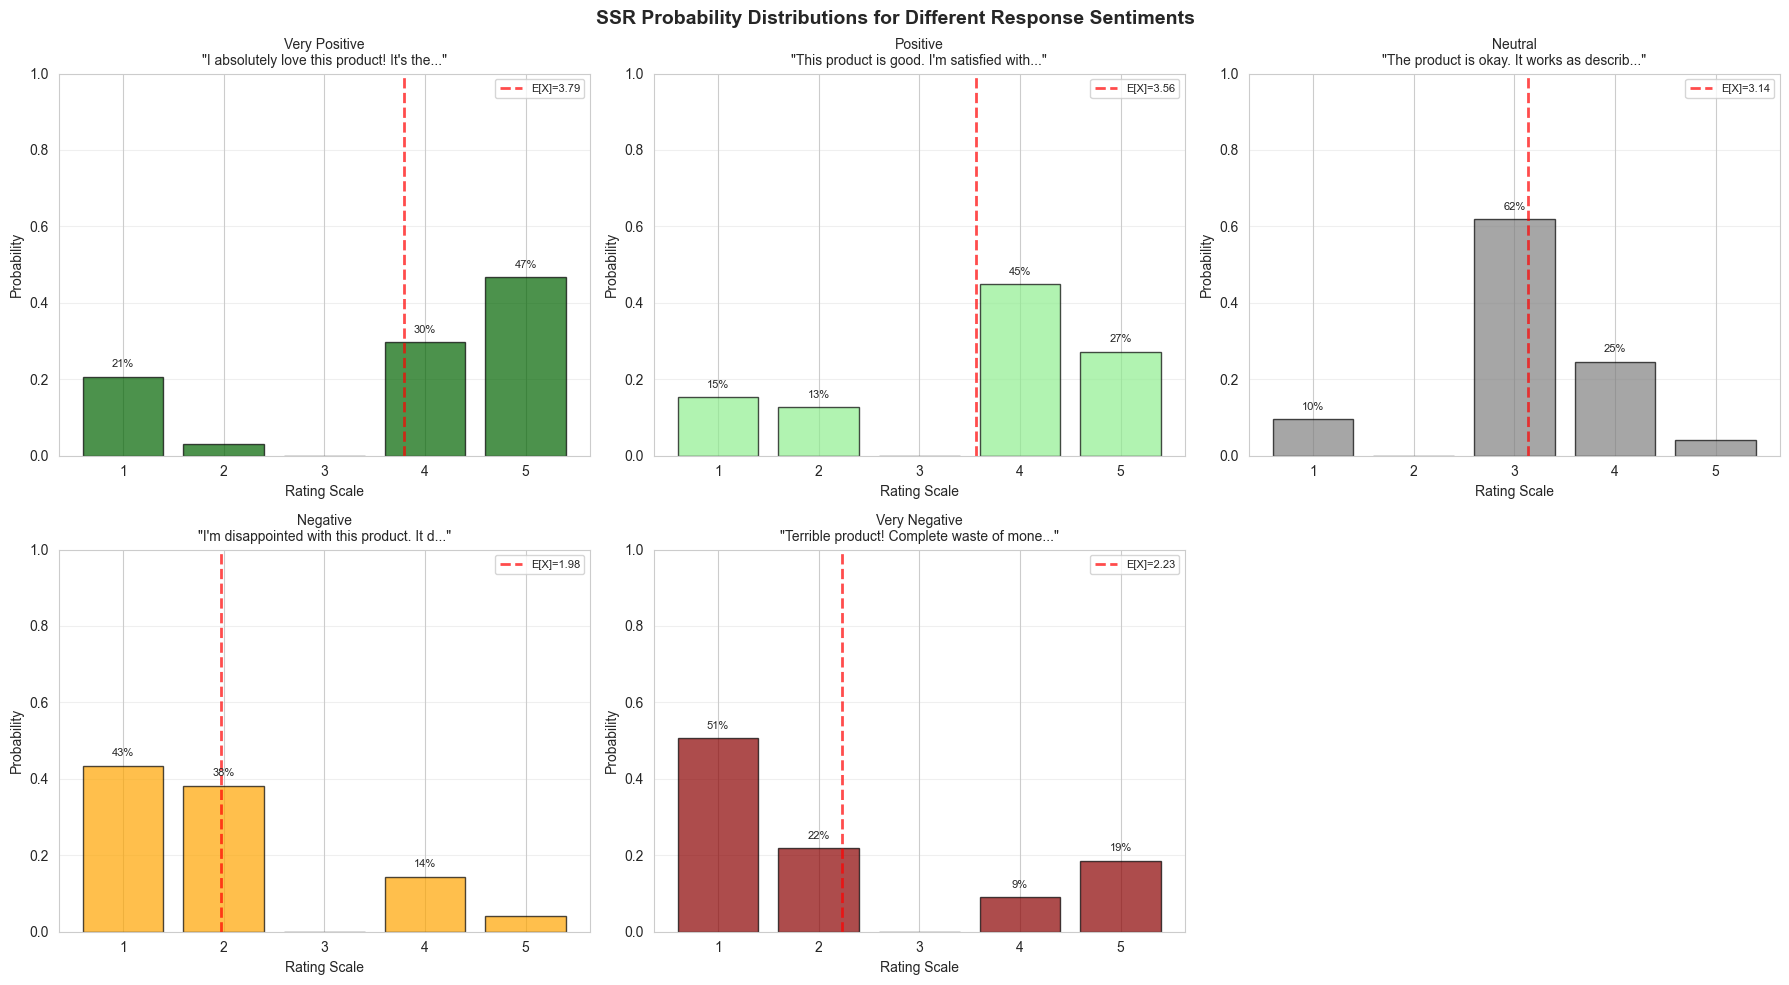

In [21]:
# Create subplots for each response
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors_map = {
    "Very Positive": 'darkgreen',
    "Positive": 'lightgreen',
    "Neutral": 'gray',
    "Negative": 'orange',
    "Very Negative": 'darkred'
}

for idx, (label, probs) in enumerate(distributions.items()):
    ax = axes[idx]
    bars = ax.bar(x, probs, color=colors_map[label], alpha=0.7, edgecolor='black')
    ax.set_title(f'{label}\n"{responses[label][:40]}..."', fontsize=10)
    ax.set_xlabel('Rating Scale')
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bar_idx, (score, prob) in enumerate(zip(x, probs)):
        if prob > 0.05:  # Only show labels for significant probabilities
            ax.text(score, prob + 0.02, f'{prob*100:.0f}%', ha='center', va='bottom', fontsize=8)
    
    # Add expected value line
    ev = np.sum(np.array(x) * probs)
    ax.axvline(ev, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'E[X]={ev:.2f}')
    ax.legend(fontsize=8)

# Hide the extra subplot
axes[5].axis('off')

plt.suptitle('SSR Probability Distributions for Different Response Sentiments', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Compare Metrics Across Responses

In [22]:
# Calculate metrics for all responses
import pandas as pd

metrics_data = []
for label, probs in distributions.items():
    mode_val = x[np.argmax(probs)]
    ev = np.sum(np.array(x) * probs)
    ent = -np.sum(probs * np.log2(probs + 1e-10))
    metrics_data.append({
        'Response Type': label,
        'Mode': mode_val,
        'Expected Value': f"{ev:.2f}",
        'Entropy': f"{ent:.3f}",
        'Certainty': 'High' if ent/max_entropy < 0.5 else 'Low'
    })

df = pd.DataFrame(metrics_data)
print("\nMetrics Comparison:")
print("=" * 80)
print(df.to_string(index=False))


Metrics Comparison:
Response Type  Mode Expected Value Entropy Certainty
Very Positive     5           3.79   1.658       Low
     Positive     4           3.56   1.821       Low
      Neutral     3           3.14   1.436       Low
     Negative     1           1.98   1.643       Low
Very Negative     1           2.23   1.740       Low


## Example 3: Temperature Parameter Effects

The **temperature** parameter controls how "peaked" or "spread out" the distribution is.

- **Low temperature** (e.g., 0.1): More concentrated distribution (higher certainty)
- **High temperature** (e.g., 2.0): More spread out distribution (lower certainty)

In [23]:
# Test different temperatures
test_response = "I really like this product, it's great!"
temperatures = [0.1, 0.3, 0.5, 1.0, 2.0]

temp_distributions = {}
for temp in temperatures:
    ssr_temp = SemanticSimilarityRater(temperature=temp, normalize_method="paper")
    sims = ssr_temp.calculate_similarities(test_response, reference_statements)
    probs = ssr_temp.similarities_to_probabilities(sims)
    temp_distributions[temp] = probs
    print(f"✓ Temperature {temp}: processed")

✓ Temperature 0.1: processed
✓ Temperature 0.3: processed
✓ Temperature 0.5: processed
✓ Temperature 1.0: processed
✓ Temperature 2.0: processed


### Visualize Temperature Effects

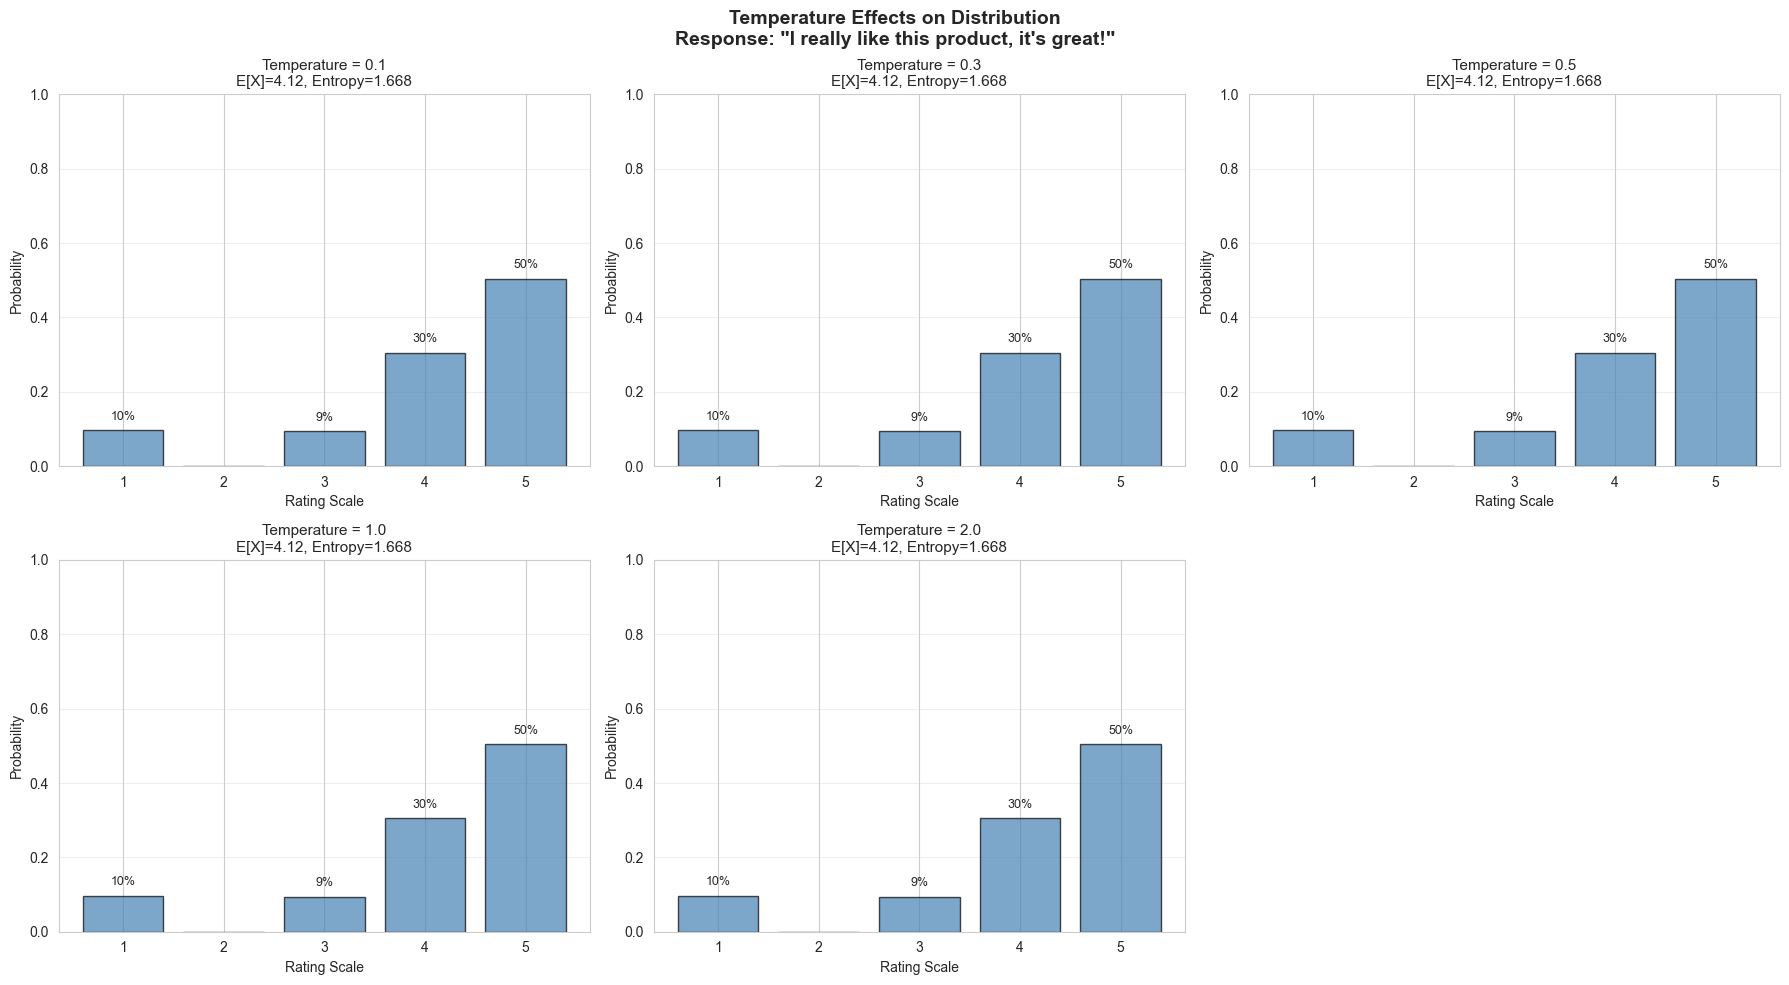


Key Observations:
- Lower temperature → More peaked distribution (higher certainty)
- Higher temperature → More spread distribution (lower certainty)
- Expected value stays relatively stable, but confidence changes


In [24]:
# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (temp, probs) in enumerate(temp_distributions.items()):
    ax = axes[idx]
    bars = ax.bar(x, probs, color='steelblue', alpha=0.7, edgecolor='black')
    
    ev = np.sum(np.array(x) * probs)
    ent = -np.sum(probs * np.log2(probs + 1e-10))
    
    ax.set_title(f'Temperature = {temp}\nE[X]={ev:.2f}, Entropy={ent:.3f}', fontsize=11)
    ax.set_xlabel('Rating Scale')
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for score, prob in zip(x, probs):
        if prob > 0.05:
            ax.text(score, prob + 0.02, f'{prob*100:.0f}%', ha='center', va='bottom', fontsize=9)

# Hide extra subplot
axes[5].axis('off')

plt.suptitle(f'Temperature Effects on Distribution\nResponse: "{test_response}"', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("=" * 80)
print("- Lower temperature → More peaked distribution (higher certainty)")
print("- Higher temperature → More spread distribution (lower certainty)")
print("- Expected value stays relatively stable, but confidence changes")

## Example 4: Normalization Methods Comparison

SSR supports three normalization methods:
1. **Paper method** (default): Subtract min + temperature scaling + proportional normalization
2. **Softmax**: Exponential scaling (common in neural networks)
3. **Linear**: Simple linear normalization

Let's compare them!

In [25]:
# Test different normalization methods
test_response = "This product is pretty good, I'm happy with it."
normalization_methods = ['paper', 'softmax', 'linear']

norm_distributions = {}
for method in normalization_methods:
    ssr_norm = SemanticSimilarityRater(temperature=0.5, normalize_method=method)
    sims = ssr_norm.calculate_similarities(test_response, reference_statements)
    probs = ssr_norm.similarities_to_probabilities(sims)
    norm_distributions[method] = probs
    print(f"✓ Method '{method}': processed")

✓ Method 'paper': processed
✓ Method 'softmax': processed
✓ Method 'linear': processed


### Visualize Normalization Method Differences

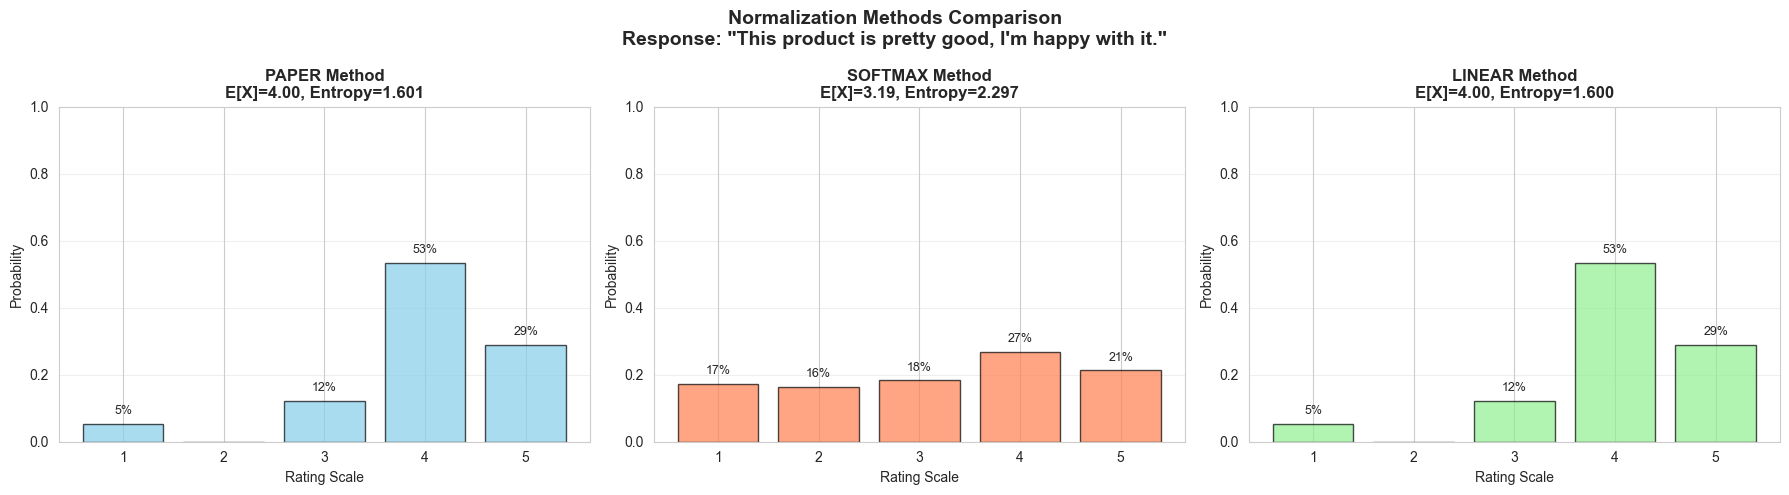

In [26]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_norm = {'paper': 'skyblue', 'softmax': 'coral', 'linear': 'lightgreen'}

for idx, (method, probs) in enumerate(norm_distributions.items()):
    ax = axes[idx]
    bars = ax.bar(x, probs, color=colors_norm[method], alpha=0.7, edgecolor='black')
    
    ev = np.sum(np.array(x) * probs)
    ent = -np.sum(probs * np.log2(probs + 1e-10))
    
    ax.set_title(f'{method.upper()} Method\nE[X]={ev:.2f}, Entropy={ent:.3f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Rating Scale')
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for score, prob in zip(x, probs):
        if prob > 0.05:
            ax.text(score, prob + 0.02, f'{prob*100:.0f}%', ha='center', va='bottom', fontsize=9)

plt.suptitle(f'Normalization Methods Comparison\nResponse: "{test_response}"', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Compare All Methods Side-by-Side

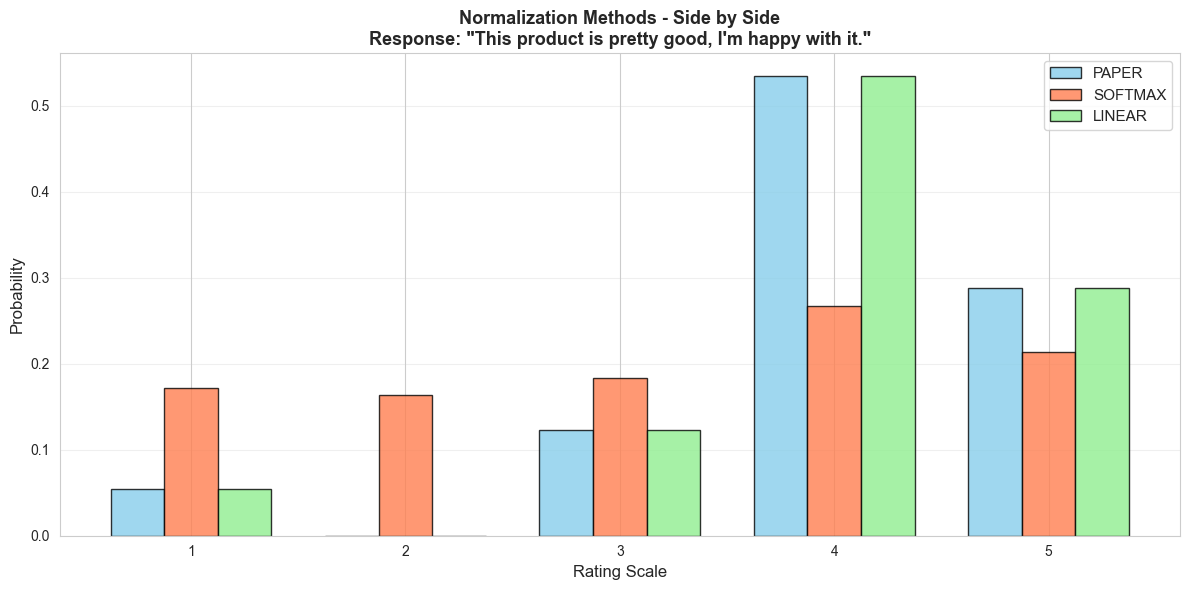


Comparison Summary:
PAPER    - Mode: 4, E[X]: 4.003
SOFTMAX  - Mode: 4, E[X]: 3.186
LINEAR   - Mode: 4, E[X]: 4.003


In [27]:
# Side-by-side comparison
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.25
x_pos = np.arange(len(x))

for idx, (method, probs) in enumerate(norm_distributions.items()):
    offset = (idx - 1) * width
    ax.bar(x_pos + offset, probs, width, label=method.upper(), alpha=0.8, color=colors_norm[method], edgecolor='black')

ax.set_xlabel('Rating Scale', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title(f'Normalization Methods - Side by Side\nResponse: "{test_response}"', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print("=" * 80)
for method, probs in norm_distributions.items():
    ev = np.sum(np.array(x) * probs)
    mode_val = x[np.argmax(probs)]
    print(f"{method.upper():8s} - Mode: {mode_val}, E[X]: {ev:.3f}")

## Example 5: Real Survey with Multiple Questions

Let's simulate a complete survey with multiple questions and analyze the results.

In [28]:
# Define a multi-question survey
survey = {
    "Q1: Product Quality": {
        "scale": rating_scale,
        "response": "The quality is outstanding! Very well-made and durable."
    },
    "Q2: Value for Money": {
        "scale": rating_scale,
        "response": "It's a bit expensive, but I think it's worth it overall."
    },
    "Q3: Customer Service": {
        "scale": rating_scale,
        "response": "The support team was helpful and responded quickly to my questions."
    },
    "Q4: Likelihood to Recommend": {
        "scale": rating_scale,
        "response": "I would definitely recommend this to friends and family."
    }
}

# Process all questions
survey_results = {}
for question, data in survey.items():
    ref_statements = list(data['scale'].values())
    sims = ssr.calculate_similarities(data['response'], ref_statements)
    probs = ssr.similarities_to_probabilities(sims)
    survey_results[question] = {
        'probabilities': probs,
        'expected_value': np.sum(np.array(x) * probs),
        'mode': x[np.argmax(probs)],
        'response': data['response']
    }
    print(f"✓ Processed: {question}")

✓ Processed: Q1: Product Quality
✓ Processed: Q2: Value for Money
✓ Processed: Q3: Customer Service
✓ Processed: Q4: Likelihood to Recommend


### Visualize Survey Results

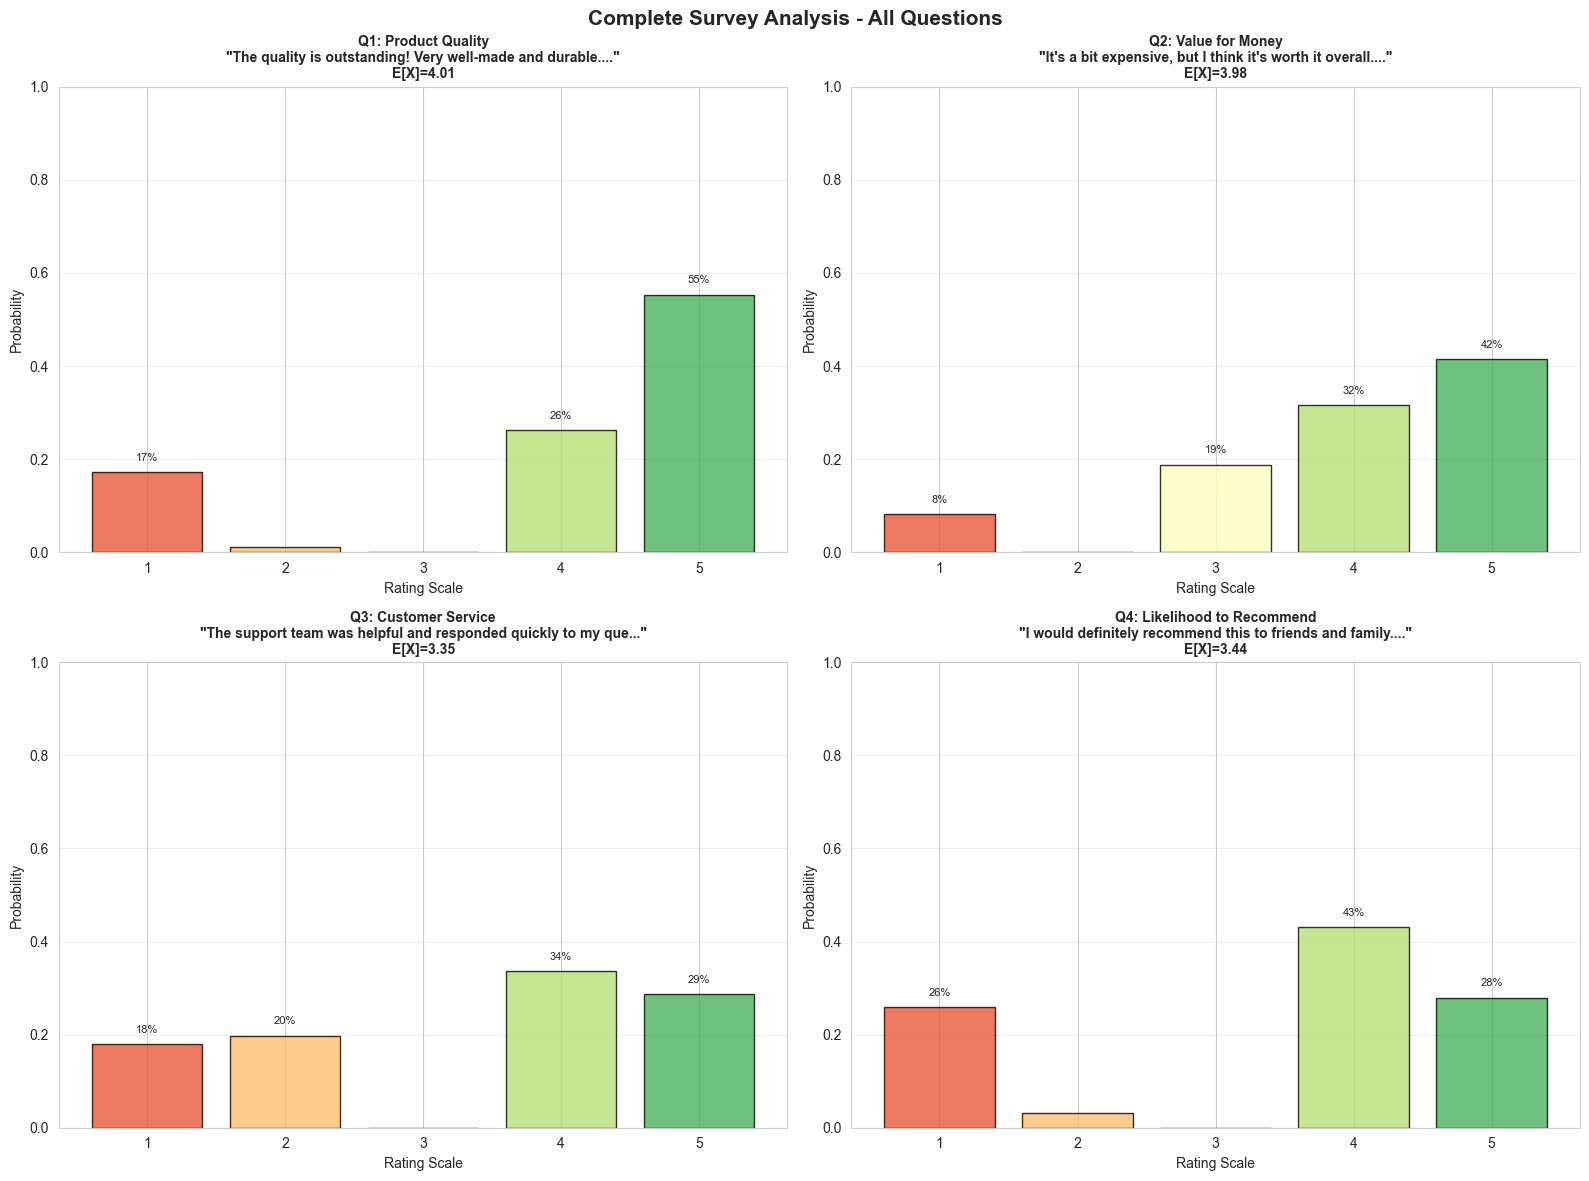

In [29]:
# Create heatmap of all distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (question, results) in enumerate(survey_results.items()):
    ax = axes[idx]
    probs = results['probabilities']
    
    bars = ax.bar(x, probs, color=sns.color_palette('RdYlGn', len(x)), alpha=0.8, edgecolor='black')
    
    # Customize
    ax.set_title(f"{question}\n\"{results['response'][:60]}...\"\nE[X]={results['expected_value']:.2f}", 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Rating Scale', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.set_xticks(x)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for score, prob in zip(x, probs):
        if prob > 0.05:
            ax.text(score, prob + 0.02, f'{prob*100:.0f}%', ha='center', va='bottom', fontsize=8)

plt.suptitle('Complete Survey Analysis - All Questions', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### Survey Summary Statistics

In [30]:
# Create summary table
summary_data = []
for question, results in survey_results.items():
    summary_data.append({
        'Question': question.split(':')[1].strip(),
        'Mode': results['mode'],
        'E[X]': f"{results['expected_value']:.2f}",
        'Response Preview': results['response'][:50] + '...'
    })

summary_df = pd.DataFrame(summary_data)
print("\nSurvey Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))

# Overall satisfaction
overall_ev = np.mean([r['expected_value'] for r in survey_results.values()])
print(f"\n{'='*100}")
print(f"Overall Satisfaction Score: {overall_ev:.2f}/5.00")
print(f"{'='*100}")


Survey Summary:
               Question  Mode E[X]                                      Response Preview
        Product Quality     5 4.01 The quality is outstanding! Very well-made and dur...
        Value for Money     5 3.98 It's a bit expensive, but I think it's worth it ov...
       Customer Service     4 3.35 The support team was helpful and responded quickly...
Likelihood to Recommend     4 3.44 I would definitely recommend this to friends and f...

Overall Satisfaction Score: 3.70/5.00


### Radar Chart of Expected Values

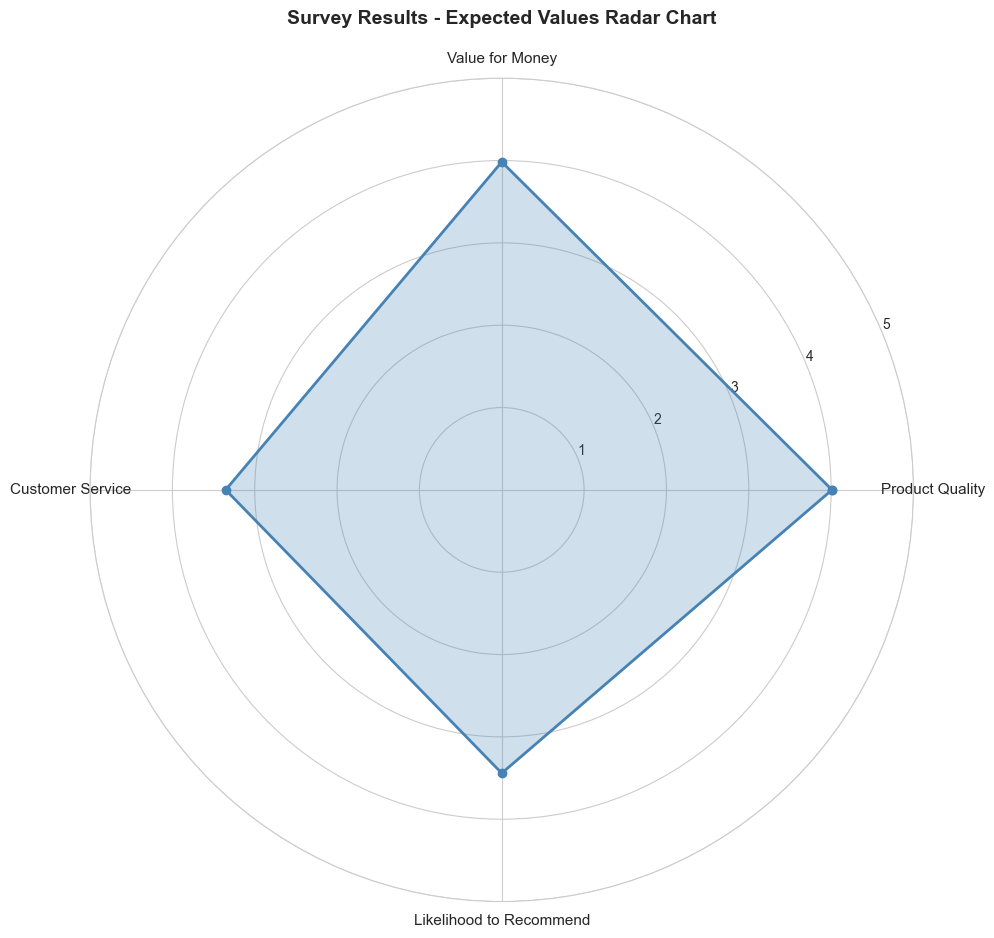

In [31]:
# Create radar chart
import math

categories = [q.split(':')[1].strip() for q in survey_results.keys()]
values = [r['expected_value'] for r in survey_results.values()]

# Number of variables
N = len(categories)

# Compute angle for each axis
angles = [n / float(N) * 2 * math.pi for n in range(N)]
values += values[:1]  # Complete the circle
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Draw the plot
ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
ax.fill(angles, values, alpha=0.25, color='steelblue')

# Fix axis to go from 0 to 5
ax.set_ylim(0, 5)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)

# Add gridlines
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'], size=10)
ax.grid(True)

plt.title('Survey Results - Expected Values Radar Chart', size=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Summary: The SSR Process

### Step-by-Step Recap:

1. **Define Rating Scale**: Create reference statements for each point on your scale
2. **Collect Text Response**: Get natural language response from respondent (human or LLM)
3. **Generate Embeddings**: Convert text to semantic vectors using embedding model
4. **Calculate Similarities**: Compute cosine similarity between response and each reference
5. **Apply Normalization**: Convert similarities to probabilities using chosen method
6. **Extract Metrics**: Calculate mode, expected value, entropy, etc.

### Key Advantages:

✓ **Rich qualitative data**: Natural language captures nuance and context  
✓ **Rigorous quantitative output**: Probability distributions enable statistical analysis  
✓ **Uncertainty quantification**: Entropy shows confidence in ratings  
✓ **Flexible scales**: Works with any rating scale (Likert, NPS, custom)  
✓ **Multi-modal support**: Can include images/webpages with vision models  

### Parameters to Tune:

- **Temperature**: Controls distribution spread (default: 0.5)
- **Normalization Method**: Paper/softmax/linear (default: paper)
- **Embedding Model**: text-embedding-3-small/large (default: small)

---

## Next Steps:

Try modifying this notebook to:
- Test your own survey questions and responses
- Experiment with different temperature values
- Compare normalization methods for your use case
- Analyze distributions from multiple respondents
- Calculate aggregate statistics across a population

**Reference Paper**: [Semantic Similarity Rating for Quantitative Survey Research (arXiv:2510.08338v2)](https://arxiv.org/abs/2510.08338)